In [134]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from scipy import signal
from misc_tools.print_latex import print_tex

***
# Graphs and Graph Neural Networks (GNNs)
Great resource: https://distill.pub/2021/gnn-intro/.

My notes are remarks and thoughts after studying this and other resources.
## What are graphs?
Graphs are useful for representing data where entries (nodes/vertices) are related in specific way (connected via edges).


Good examples of graphs are connections in social networks and molecular structures.

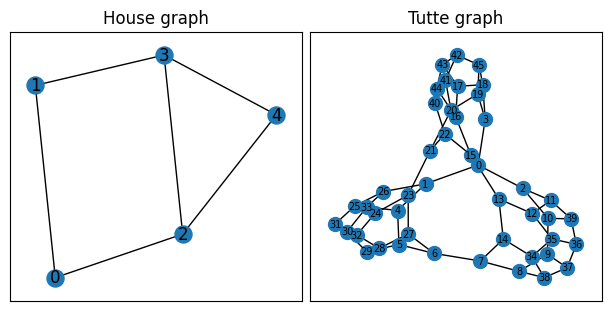

In [48]:
np.random.seed(1337)
G_house = nx.house_graph()
G_tutte = nx.tutte_graph()
fig, ax = plt.subplots(1, 2, figsize = (6,3), layout='constrained')
nx.draw_networkx(G_house, node_size = 150, ax=ax[0])
ax[0].set_title('House graph');
nx.draw_networkx(G_tutte, node_size = 100, ax=ax[1], font_size = 7)
ax[1].set_title('Tutte graph');

## Connectivity (graph degree)
Connectivity 'bakes in' an important information about data structure\\-s and allows to extract deeper relations.

It is common to represent graph as $G$, its nodes/vertices as set $V = \{ v_i \}_{i=1}^n $ and edges as set $E = \{ (i,j) \}_{i.j = 1}^n$

Connectivity can be represented via adjacency matrix $A$ where entry $A_{i,j} = \{0,1\}$ shows whether node $v_i$ and node $v_j$ are connected

In case of undirected graph, matrix A is symmetric

In [56]:
A = nx.adjacency_matrix(G_house).todense()
print_tex('A =', A)

<IPython.core.display.Math object>

You can calculate individual node connectivity (called degree) and average connectivity of a graph:

In [88]:
print_tex(';\ '.join([f'degree(n_{n})={i}' for n,i in G_house.degree()]))
print('Number of nodes', len(G_house.nodes))
print('Number of edges', len(G_house.edges))
print('Average degree', sum(dict(G_house.degree).values()) / len(G_house.nodes))

<IPython.core.display.Math object>

Number of nodes 5
Number of edges 6
Average degree 2.4


# Connectivity in convolution/cross-correlation
Closest data processing method that leverages connectivity/locality is a convolution operation.<br>
Which is why its successfully used in convolutional neural networks (CNNs).

In image data, connectivity is as large as convolutional kernel.

### Here is an example of measuring number of neighbors using a kernel

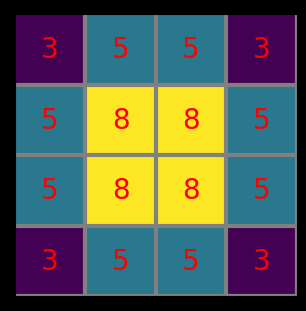

In [254]:
def neighbor_count(x): 
    k = np.ones((x,x))
    k[x//2,x//2] = 0    # dont count center pixel
    return k

def rem_ticks(ax, ticks, lw = 1):
    for a in ax:
        a.set_xticks(ticks);a.set_yticks(ticks);a.set_xticklabels([]);a.set_yticklabels([]);a.grid(color='gray', lw = lw)
        a.tick_params(colors=(0,0,0,0));

img = np.ones((4,4))
num_neighbors = signal.convolve2d(img, neighbor_count(3), boundary='fill', mode='same', fillvalue=0)# pad zeros

fig, ax = plt.subplots(1,1, figsize = (6,3), layout='constrained', facecolor = 'k')
ax = [ax]
ax[0].matshow(num_neighbors)
for (i,j), v in np.ndenumerate(num_neighbors):
    ax[0].text(i, j, int(v), va='center', ha='center', color = 'Red', fontsize = 20)
rem_ticks(ax, np.arange(0.5, 4, 1), lw = 3)


### 'Propagation of information' using convolution
Number of neighbors sets a limit on how far information can propagate:

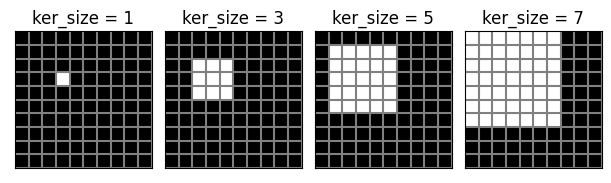

In [262]:
img = np.zeros((10,10))
img[3,3] = 1

ticks = np.arange(0.5, 10, 1)
fig, ax = plt.subplots(1,4, figsize = (6,3), layout='constrained')

ker = lambda x: np.ones((x,x))/x**2

rem_ticks(ax,ticks, lw = 1.5)
ker_size = 1
for i in range(4):
    img2 = img.copy()
    img2 = signal.convolve2d(img2, ker(ker_size), boundary='symm', mode='same')
    ax[i].imshow(img2, 'gray')
    ax[i].set_title(f'{ker_size = }')
    ker_size += 2

Alternatively, we can apply kernel of a given size repeatedly.

Repeated application of a method  reminds of working principle of Recurrent Neural Networks (RNN), where data is cyclically processed in a RNN cell, in a process which is called **'unfolding'**.

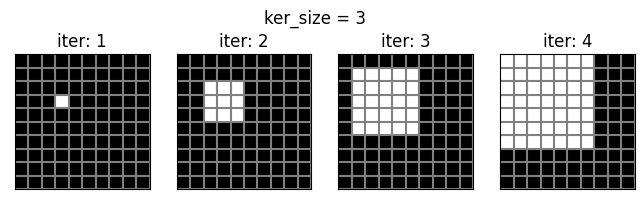

In [261]:
ker_size = 3
fig, ax = plt.subplots(1,4, figsize = (8,5))
rem_ticks(ax,ticks, lw = 1.5)
fig.suptitle(f'{ker_size = }')
plt.subplots_adjust(top=1.4)
img2 = img.copy()

for i in range(4):
    ax[i].imshow(img2 > 0, 'gray')
    img2 = signal.convolve2d(img2, ker(ker_size), boundary='symm', mode='same')
    ax[i].set_title(f'iter: {i + 1}')


<b>Takeaway</b>- information can be propagated via:
1. long connections (here kernel size)
2. 'diffused' via repeated shorter queries

This idea can be applied to methods that process graphs- <br>
we can change state of a graph based on information stored in nodes and their neighbors, via parameters stored in edges.

In a sense, all graph element parameters can be diffused via function appropriate to our task.
***

## Graph Neural Networks (GNNs)

### Deep Learning (DL) approach
GNNs, like most Deep Learning NNs, operate with large matrices, computation of which is accelerated via CPU/GPU parallelization.

How can we leverage benefit of matrices in case of graph data?

Given nodes (and edges)
$$V = \{n_1, n_2,\dots , n_n\}$$
We can assign them features $\vec{f}_i \in n_i$, which are numbers or vectors of set dimensions (i.e hot-encoding).

Features can be easily packed into matrix $N$ of shape $(\mathrm{len}(\vec{f}_i), N_{nodes})$
$$ N = 
\begin{bmatrix}
\vec{f}_1 & \vec{f}_2 &  \dots & \vec{f}_n
\end{bmatrix}
$$
In theory, features alone or these matrices via standard DL approach:
$$\vec{y}_f = \sigma(W_f \vec{f} + \vec{b}_f)$$
$$y_N = \sigma(W_n N + \vec{b_n})$$

Edge features can be packed in similar fashion, and edge connectivity represented as <b>adjacency matrix</b>.

### Representing graph data as a matrix (spoilers: it fails)
But, because graphs are constructed of <b>unordered</b> data, there is no consistent/unique way to represent it as matrices.

i.e for edges of nodes $$E = \{(n_1,n_2),(n_3,n_1)\}$$ and
$$V_1 = \{n_1,n_2,n_3\} \rightarrow 
A_1 = 
\begin{bmatrix}
    & V_1[1]   & V_1[2]   & V_1[3]\\
V_1[1] & 0     & 1     & 0\\
V_1[2] & 0     & 0     & 0\\
V_1[3] & 1     & 0     & 0\\
\end{bmatrix}
$$

and for same nodes presented in different order ($n_1 \circlearrowright n_3$):

$$V_2 = \{n_3,n_2,n_1\} \rightarrow 
A_2 = 
\begin{bmatrix}
    & V_2[1]   & V_2[2]   & V_2[3]\\
V_2[1] & 0     & 0     & 1\\
V_2[2] & 0     & 0     & 0\\
V_2[3] & 0     & 1     & 0\\
\end{bmatrix}
$$

Results in <b>different adjacency matrix. </b>

<i>Its worth mentioning that features are of set dimensions and can be processed via Deep Learning before considering connectivity, but representing whole graph one matrix fails.</i>

### Permutation invariance/aggregation/message passing
GNN should be constructed in a way so order of input nodes does not influence learning (GNN should be node <i>permutation invariant</i>).

Additionally, adding more nodes will increase size of adjacency matrix and weights (i.e $W_N$) will be invalidated.

Similar problems arise if we want to exploit <b>connectivity</b> of node $n_i$ with its <i>neighborhood $\mathcal{N}(n_i)$.</i><br>
It is simply impossible to do via matrix multiplication due to variable neighbor count and unspecified order.

In fact, DL approach is applicable only after we reduce features of $n_i$ and $\mathcal{N}(n_i)$ into a single feature vector, in a way thats neighbor count and order invariant.
<br>
This is procedure is called <i> aggregation</i> and we can denote it by $\rho_{n_i \rightarrow n_i}$

Such count and permutation invariant functions are:
* sum($f_1, f_2, f_3$) = sum($f_3, f_1, f_2$) 
* mean($f_1, f_2, f_3$) = mean($f_3, f_1, f_2$)
* max($f_1, f_2, f_3$) = max($f_3, f_1, f_2$)

Aggregation $\rho_{n_i \rightarrow n_i}$ is done for every node and connectivity information is contained within aggregated feature vector <b>implicitly</b>.<br>
By performing aggregation multiple times or by increasing neighborhood radius, we can propagate information for longer 'distances'.<br>
This is very similar to previously shown convolution operation, except here connectivity (neighborhood) radius is not bound by geometric terms.

Proper term for such information 'diffusion' is <b>Message Passing</b>

### Node, Edge, Global task level (predictions)
Once node or edge features are 'distilled' into one agglomerated feature vector, we use it for predicting or modifying other features.

Using DL, model can learn linear maps that modify features of nodes based on edge features, or other way around.

At some instance it may be required to pool (agglomerate) features from all nodes/edges, which is called Global Prediction.